## Read me

This project uses PRAW (Python Reddit API Wrapper), which requires Reddit OAuth2 credentials to function properly.
To get started, please refer to Reddit’s OAuth2 Quick Start Guide (https://github.com/reddit-archive/reddit/wiki/OAuth2) for setup instructions.

In [ ]:
import praw
import pandas as pd
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud,STOPWORDS

# Web Scraping

## Scraping Reddit Posts with Praw

In [ ]:
# Initiating praw
reddit = praw.Reddit(user_agent_= True,
                    client_id = '',   # Fill in Reddit API keys for scraping
                    client_secret = "",
                    user_agent = "",  
)

# Selecting Subreddit
subreddit = reddit.subreddit("pettyrevenge")

# Creating the list for storage
title = []
body = []
url = []

# Appending the array
for post in subreddit.hot(limit = 100):
    title.append(post.title),
    body.append(post.selftext),
    url.append(post.url)
    
# Creating a df to store scrapped data
df = pd.DataFrame({
    'title': title,
    'body': body,
    'url': url
})


# Text Analysis

## 2.1 - Sentiment Analysis with Sentiment Intensity Analyzer

In [8]:
# Initiate the analyzer
sentiment = SentimentIntensityAnalyzer()

# Creating an empty list for storage
neg = []
neu = []
pos = []
comp = []

# Performing text analysis on all reddit posts
for post in df['body'].values:
    # Text analysis using Vader
    scores = sentiment.polarity_scores(post)
    
    # Appending the scores
    neg.append(scores['neg'])
    neu.append(scores['neu'])
    pos.append(scores['pos'])
    comp.append(scores['compound'])

# Appending the scores to the df
# df['neg'] = neg
# df['neu'] = neu
# df['pos'] = pos
df['sentiment_score'] = comp

In [9]:
# Inspecting the range of sentiment score
print(f'The highest sentiment score (positive sentiment) is: {df['sentiment_score'].max()}')
print(f'The lowest sentiment score (negative sentiment) is: {df['sentiment_score'].min()}')

# Inspect the range of the score
range = df['sentiment_score'].max() - df['sentiment_score'].min()
print(f'The range of the score is {range:.2f}')


The highest sentiment score (positive sentiment) is: 0.9975
The lowest sentiment score (negative sentiment) is: -0.9991
The range of the score is 2.00


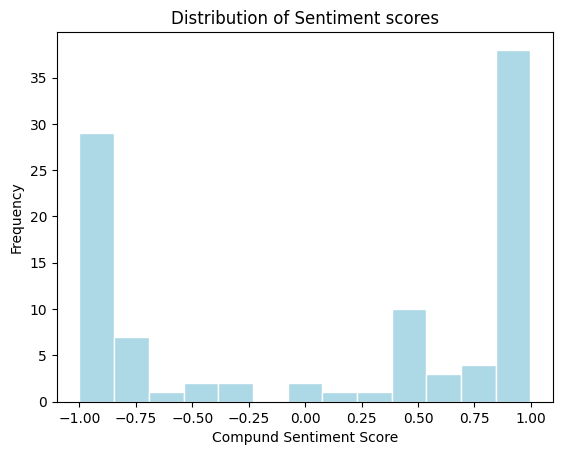

In [10]:
# Visualizing the distribution
plt.hist(df['sentiment_score'], color = 'lightblue', edgecolor = 'white', 
         bins = int(range/0.15))

# Adding labels to the graph
plt.title('Distribution of Sentiment scores')
plt.xlabel('Compund Sentiment Score')
plt.ylabel('Frequency')

plt.show()

## 2.2 - Word Importance Analysis with Scikit-Learn TF-IDF

In [11]:
# Initialize TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words = 'english', min_df = 2, max_df = 0.8)

# Fit and transform the document
tfidf_matrix = vectorizer.fit_transform(df['body'])

# Convert the matrix to a DataFrame for readability:
df_tfidf = pd.DataFrame(tfidf_matrix.todense(), 
                        columns = vectorizer.get_feature_names_out())

# Determining the dimentions
df_tfidf.shape

(100, 1852)

In [13]:
# Getting the total number of non zero columns
non_zero_col = (df_tfidf != 0).sum(axis = 1)

# Calculating the compound TF-IDF scores
tfidf_total = df_tfidf.sum(axis = 1)
avg_tfidf = tfidf_total / non_zero_col

# Adding the scores to the df
df['avg_tfidf'] = avg_tfidf

# Saving the results to csv
df.to_csv('data/scrap_result_praw.csv', index = False)

# Inspecting df
df.head()

,title,body,url,sentiment_score,avg_tfidf
0,My contractor coworker quit with 10 seconds no...,I worked an engineering contract for a while. ...,https://www.reddit.com/r/pettyrevenge/comments...,0.9859,0.091027
1,Abandon your kid on the road as a punishment? ...,I feel like this is pretty minor petty revenge...,https://www.reddit.com/r/pettyrevenge/comments...,-0.9773,0.046602
2,To the doordasher who stood and STARED at me t...,I do apologize for whoever was waiting on thei...,https://www.reddit.com/r/pettyrevenge/comments...,0.9355,0.121695
3,toilet revenge,Years ago I worked cleaning houses. I had one ...,https://www.reddit.com/r/pettyrevenge/comments...,0.9556,0.083261
4,Let’s see how long the honeymoon lasts…,"Very gently petty, but a good story.\n\nThis i...",https://www.reddit.com/r/pettyrevenge/comments...,0.9458,0.065565


## Text Clouds

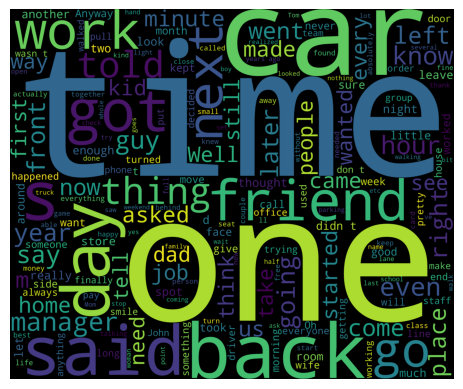

In [ ]:
# Sentiment Positive

df_pos = df[df['sentiment_score']>=0.5]
words = ' '.join(df_pos['body'].astype(str))
cleaned_word = ' '.join([word for word in words.split() if not word.startswith('@')])

wordcloud = WordCloud(background_color='black',stopwords=STOPWORDS,
                      width=3000, height=2500).generate(''.join(cleaned_word))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

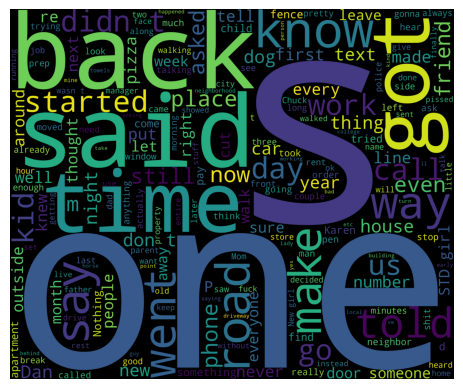

In [19]:
# Sentiment Negative

df_neg = df[df['sentiment_score']<=-0.5]
words = ' '.join(df_neg['body'].astype(str))
cleaned_word = ' '.join([word for word in words.split() if not word.startswith('@')])

wordcloud = WordCloud(background_color='black',stopwords=STOPWORDS,
                      width=3000, height=2500).generate(''.join(cleaned_word))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()